In [1]:
# importing relevent library
import pandas as pd
import numpy as np
# import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

sns.set() # all plot will cover on seaborn style

In [3]:
car = pd.read_csv('Car_cleaned.csv')
car.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


Text(0.5, 1.0, 'Mileage Vs Price')

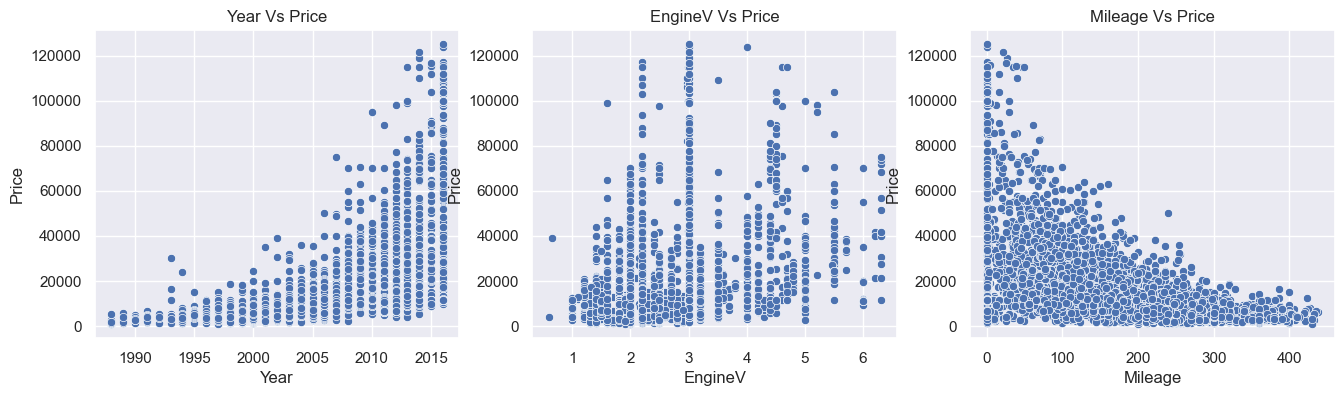

In [4]:
# plotting all the three numerical columns
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
sns.scatterplot(x=car['Year'], y=car['Price']);
plt.title('Year Vs Price');

plt.subplot(1,3,2)
sns.scatterplot(x=car['EngineV'], y=car['Price']);
plt.title('EngineV Vs Price');

plt.subplot(1,3,3)
sns.scatterplot(x=car['Mileage'], y=car['Price']);
plt.title('Mileage Vs Price')

In [5]:
log_price = np.log(car['Price'])

# adding another column 
car['log_price'] = log_price

# checking the data again
car.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656


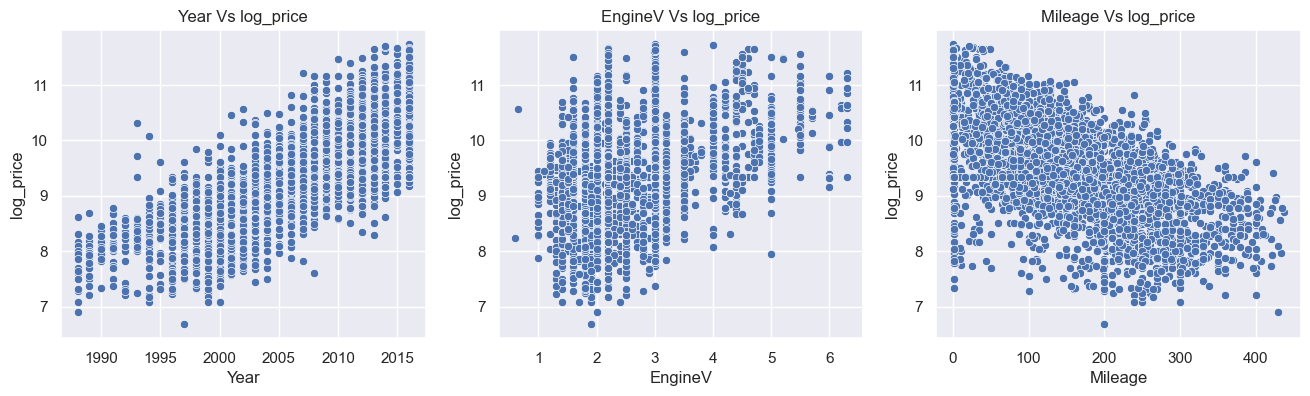

In [6]:
# plotting all the three numerical columns again with log price
plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
sns.scatterplot(x=car['Year'], y=car['log_price']);
plt.title('Year Vs log_price');

plt.subplot(1,3,2)
sns.scatterplot(x=car['EngineV'], y=car['log_price']);
plt.title('EngineV Vs log_price');

plt.subplot(1,3,3)
sns.scatterplot(x=car['Mileage'], y=car['log_price']);
plt.title('Mileage Vs log_price');

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import numpy as np

# Load the dataset
file_path = '/mnt/data/Car_Raw_Data.csv'
car_data = pd.read_csv('Car_cleaned.csv')

# Data cleaning: Handle missing values by dropping rows with missing Price or EngineV
car_data_cleaned = car_data.dropna(subset=['Price', 'EngineV'])

# Log-transform the Price column to stabilize variance
car_data_cleaned['Price'] = np.log1p(car_data_cleaned['Price'])

# Convert 'Registration' column to binary (1 for 'yes', 0 for 'no')
car_data_cleaned['Registration'] = car_data_cleaned['Registration'].map({'yes': 1, 'no': 0})

# One-hot encode categorical columns
categorical_cols = ['Brand', 'Body', 'Engine Type', 'Model']
car_data_encoded = pd.get_dummies(car_data_cleaned, columns=categorical_cols, drop_first=True)

# Define features (X) and target variable (y)
X = car_data_encoded.drop(columns=['Price'])
y = car_data_encoded['Price']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Reverse log transformation for comparison
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Calculate RMSE and R^2
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

# Calculate accuracy (percentage of predictions within a reasonable range, e.g., 20%)
accuracy = np.mean(np.abs(y_pred_actual - y_test_actual) / y_test_actual <= 0.2) * 100

# Display results
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)
print("Accuracy (within 20% of actual values):", accuracy, "%")

# Compare predicted values with actual values
comparison = pd.DataFrame({
    'Actual': y_test_actual,
    'Predicted': y_pred_actual
})
print("\nComparison of Actual vs Predicted values:")
print(comparison.head(10))  # Display the first 10 comparisons

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Root Mean Squared Error (RMSE): 11282.914580381394
R-squared (R^2): 0.5952009458504426
Accuracy (within 20% of actual values): 70.2994011976048 %

Comparison of Actual vs Predicted values:
       Actual     Predicted
1451   4500.0   6297.698599
2258  25200.0  25014.432100
731   11700.0  12089.286326
544   13500.0  33024.495680
2457  12950.0  11189.072503
109   19200.0  14907.118543
1315  21200.0  19018.411906
1034   6400.0   5993.717597
1055   9500.0   7037.276057
2242  22000.0  21248.185526

Top 10 Most Important Features:
                 Feature  Importance
3                   Year    0.578226
1                EngineV    0.182966
2           Registration    0.072897
0                Mileage    0.048227
7          Brand_Renault    0.007604
5    Brand_Mercedes-Benz    0.006627
176         Model_Kangoo    0.006175
4              Brand_BMW    0.005812
12            Body_sedan    0.004351
6       Brand_Mitsubishi    0.004051
